# MSEPM Blood 450k Data Processing
    - This notebook contains the workflow for downloading and processing 450k array data from GEO using a minfi workflow for the MSEPM Blood models.

- R Software Versions (R 4.1.2)
    - LOLA_1.24.0                               
    - FlowSorted.Blood.450k_1.32.0              
    - IlluminaHumanMethylation450kmanifest_0.4.0
    - minfi_1.40.0                              
    - bumphunter_1.36.0                         
    - locfit_1.5-9.6                            
    - iterators_1.0.14                          
    - foreach_1.5.2                             
    - Biostrings_2.62.0                         
    - XVector_0.34.0                            
    - SummarizedExperiment_1.24.0               
    - Biobase_2.54.0                            
    - MatrixGenerics_1.6.0                      
    - matrixStats_0.62.0                        
    - GenomicRanges_1.46.1                      
    - GenomeInfoDb_1.30.1                       
    - IRanges_2.28.0                            
    - S4Vectors_0.32.4                          
    - BiocGenerics_0.40.0 

## Notebook Setup

In [1]:
from collections import Counter, defaultdict
from ftplib import FTP
import gzip
import io
import math
import os 
import pkg_resources
import pickle
import random
import shutil
import subprocess
import sys
from typing import Dict, List, Union

from IPython.display import display, HTML
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from SeriesMatrixMetaExtractor import SeriesMatrixMetaExtractor

In [2]:
def get_session_info(import_diff_modules=[]):
    '''
    Retrieve python version and list of imported packages that 
    are imported directly or as dependencies:
        Args:
            import_diff_modules (List[str]): list of modules that have different install and 
                                        import names, ie scikit-learn imported with sklearn
        Returns:
            Dict[str, str]: package_name : version 
    '''
    local_pkgs = {str(i).split()[0]:str(i).split()[1] for i in pkg_resources.working_set}
    session_pkgs = {'Python':sys.version}
    for pkg in sorted(list(set([x.split('.')[0] for x in sys.modules])) + import_diff_modules):
        if pkg in local_pkgs:
            session_pkgs[pkg] = local_pkgs[pkg]
    return session_pkgs

In [3]:
# collect session info
session_info = get_session_info(import_diff_modules=['scikit-learn'])

In [4]:
display(HTML(pd.DataFrame(session_info, index=['Package', 'Version']).T.to_html()))

,Package,Version
Python,"3.10.4 (main, May 3 2022, 09:55:33) [GCC 11.2.0]","3.10.4 (main, May 3 2022, 09:55:33) [GCC 11.2.0]"
asttokens,2.0.5,2.0.5
backcall,0.2.0,0.2.0
cffi,1.15.0,1.15.0
cycler,0.11.0,0.11.0
debugpy,1.6.0,1.6.0
decorator,5.1.1,5.1.1
defusedxml,0.7.1,0.7.1
entrypoints,0.4,0.4
executing,0.8.3,0.8.3


## Set Data Procesing File Structure

In [5]:
working_dir = os.getcwd()

In [6]:
idat_dir = os.path.join(working_dir, 'IdatFiles')

In [7]:
tmp_dir = os.path.join(working_dir, 'tmp')

In [8]:
processed_file_dir = os.path.join(working_dir, 'ProcessedData')

In [9]:
exp_series_dir = os.path.join(working_dir, 'SeriesMatrices')

In [10]:
for directory in [idat_dir, processed_file_dir, 
                  exp_series_dir, tmp_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

## Parse Experiment GEO Information

In [11]:
def parse_meta_data(file_path, platform_id):
    with open(file_path, 'r') as meta:
        all_exps = {}
        exp_info = {}
        for line in meta:
            line_strip = line.strip()
            if not line_strip:
                if exp_info:
                    all_exps[exp_info['accession_id']] = exp_info
                exp_info = {}
            else:
                if not exp_info:
                    exp_info['title'] = ' '.join(line_strip.split(' ')[1:])
                elif '(Submitter supplied)' in line_strip:
                    exp_info['description'] = line_strip.replace('(Submitter supplied) ', '')
                elif 'Organism' in line_strip:
                    exp_info['organism'] = line_strip.split(':')[1].strip()
                elif 'Platform' in line_strip:
                    line_split = line_strip.split(' ')
                    exp_info['platform_id'] = platform_id
                    exp_info['sample_number'] = int(line_split[-2])
                elif 'FTP' in line_strip:
                    exp_info['ftp_link'] = line_strip.split(' ')[-1]
                elif 'Series' in line_strip:
                    line_split = line_strip.split('\t')
                    exp_info['accession_id'] = line_strip.split(': ')[1].split('\t')[0]
    return all_exps

In [12]:
msepm_blood_exps = parse_meta_data(os.path.join(working_dir, 'UniversalBloodExps.txt'), 'GPL13534')

## Retrieve Experiment Metadata

In [13]:
def retrieve_exp_info(exp):
    file_links = {}
    raw_url = exp['ftp_link']
    processed_link = raw_url.replace('ftp://', '').split('/')[0]
    exp_dir = '/'.join(raw_url.replace('ftp://', '').split('/')[1:])
    ftp = FTP(processed_link)
    ftp.login()
    ftp.cwd(exp_dir)
    directories = ftp.nlst()
    for direct in directories:
        ftp.cwd(direct)
        files = ftp.nlst()
        file_links[direct] = (ftp.pwd(), files)
        ftp.cwd('..')
    if 'suppl' in file_links:
        if 'filelist.txt' in file_links['suppl'][1]:
            ftp.cwd('suppl')
            supp_lines = []
            ftp.retrlines('RETR filelist.txt', supp_lines.append)
            file_links['supplemental_files'] = supp_lines
    ftp.close()
    return exp['accession_id'], f'ftp://{processed_link}', file_links

In [14]:
processed_links = joblib.Parallel(n_jobs=8, verbose=10)(joblib.delayed(retrieve_exp_info)(exp) for exp in msepm_blood_exps.values())

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done   5 out of  18 | elapsed:    7.0s remaining:   18.2s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    7.0s remaining:   11.0s
[Parallel(n_jobs=8)]: Done   9 out of  18 | elapsed:   13.0s remaining:   13.0s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:   13.3s remaining:    8.5s
[Parallel(n_jobs=8)]: Done  13 out of  18 | elapsed:   13.3s remaining:    5.1s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:   13.3s remaining:    2.7s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:   19.4s finished


In [15]:
for exp_id, ftp_head, links in processed_links:
    msepm_blood_exps[exp_id].update(links)
    msepm_blood_exps[exp_id]['ftp_head'] = ftp_head

In [16]:
idat_exps = []
idat_sample_count = 0

for exp_id, exp in msepm_blood_exps.items():
    supp_files = exp.get('supplemental_files', [])
    for file in supp_files:
        if 'IDAT' in file.upper():
            idat_exps.append(exp_id)
            idat_sample_count += exp['sample_number']
            break

In [17]:
idat_exp_info = {key: value for key, value in msepm_blood_exps.items() if key in idat_exps}

## Dowload series matrix files for files with IDAT files available

In [18]:
def download_series_matrix(exp, output_directory):
    matrix_head, files = exp.get('matrix', (None, None))
    if not matrix_head:
        return exp['accession_id']
    else:
        series_head = f'{exp["ftp_head"]}/{matrix_head}/'
        series_file = None
        if len(files) == 1:
            series_file = files[0]
        else:
            for file in files:
                if exp['platform_id'].upper() in file.upper():
                    series_file = file
        if not series_file:
            return exp['accession_id']
        if os.path.exists(os.path.join(output_directory, series_file)):
            return 0
        wget_command = ['wget', '-q', '-nd', '-P',
                        output_directory, f'{series_head}{series_file}']
        p = subprocess.Popen(args=wget_command)
        p.wait()
        if p.returncode:
            return exp['accession_id']
        else:
            return 0

In [19]:
download_status = joblib.Parallel(n_jobs=16, verbose=10)(joblib.delayed(download_series_matrix)
                                                         (*[msepm_blood_exps[exp], exp_series_dir]) for exp in idat_exps)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.1569s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   3 out of  18 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=16)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=16)]: Done   7 out of  18 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=16)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  11 out of  18 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  13 out of  18 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  15 out of  18 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  18 out of  18 | elapsed:    0.2s finished


## Parse Series Matrices to Extract MetaData 

In [20]:
def extract_meta(exp, series_directory):
    matrix_head, files = exp.get('matrix', (None, None))
    series_file = None
    if len(files) == 1:
        series_file = files[0]
    else:
        for file in files:
            if exp['platform_id'].upper() in file.upper():
                series_file = file
    directory = series_directory if series_directory.endswith('/') else f'{series_directory}/'
    series_path = f'{directory}{series_file}'
    matrix_parser = SeriesMatrixMetaExtractor(series_matrix_path=series_path, sample_id='!Sample_geo_accession', phenotype_ids=['!Sample_characteristics_ch1'])
    matrix_parser.get_meta_data()
    return matrix_parser.phenotype_matrix 

In [21]:
exp_sample_meta = joblib.Parallel(n_jobs=8, verbose=10)(joblib.delayed(extract_meta)(*[exp, exp_series_dir]) for exp in idat_exp_info.values())
all_meta = {}
for exp in exp_sample_meta:
    all_meta.update(exp)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.1588s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   7 out of  18 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  11 out of  18 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  13 out of  18 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  15 out of  18 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.2s finished


### Update Meta with File Info

In [22]:
def get_sample_idat_meta(gsm_id, gsm_info, supp_files):
    idat_files = {}
    for file in supp_files:
        if gsm_id in file:
            file_name, file_date = file.strip().split('\t')[1:3]
            gsm_dir = ''.join(list(gsm_id)[0:-3]) + 'nnn'
            sample_ftp_head = f'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/{gsm_dir}/{gsm_id}'
            idat_files['ftp_head'] = sample_ftp_head
            if 'grn' in file_name.lower():
                idat_files['Grn'] = file_name
            elif 'red' in file_name.lower():
                idat_files['Red'] = file_name
            idat_files['idat_date'] = file_date
    return gsm_id, idat_files

In [23]:
sample_idat_links = joblib.Parallel(n_jobs=2, verbose=10)(joblib.delayed(get_sample_idat_meta)
                                                          (*[gsm_id, gsm_info, idat_exp_info[gsm_info['experiment_id']]['supplemental_files']]) for gsm_id, gsm_info in all_meta.items())

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1344s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0061s.) Setting batch_size=4.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0015s.) Setting batch_size=8.
[Parallel(n_jobs=2)]: Batch computation too fast (0.0018s.) Setting batch_size=16.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0036s.) Setting batch_size=32.
[Parallel(n_jobs=2)]: Done 156 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0086s.) Setting batch_size=64.
[Parallel(n_jobs=2)]: Batch computation too fast (0.0138s.) Setting batch_size=128.
[Parallel(n_jobs=2)]: Done 508 tasks     

In [24]:
idat_sample_meta = {}
for gsm_id, idat_links in sample_idat_links:
    if len(idat_links) > 0:
        sample_info = all_meta[gsm_id]
        sample_info.update(idat_links)
        idat_sample_meta[gsm_id] = sample_info

### Explore Phenotype Data 

In [25]:
def search_for_age(gsm_meta: dict) -> bool:
    for key in gsm_meta:
        if 'age' in key.lower() and 'stage' not in key.lower():
            return True
    return False

In [26]:
idat_age_meta = {key:value for key, value in idat_sample_meta.items() if search_for_age(value)}

In [27]:
idat_age_exps = set(gsm_meta['experiment_id'] for gsm_meta in idat_age_meta.values())
idat_exps = {key:value for key, value in idat_exp_info.items() if key in idat_age_exps}

In [28]:
idat_sample_meta = {gsm_id: gsm_meta for gsm_id, gsm_meta in idat_sample_meta.items() if gsm_meta['experiment_id'] in idat_exps}

In [29]:
age_cats = set()
ages = []

for gsm_id in tqdm(idat_sample_meta):
    gsm_meta = dict(idat_sample_meta[gsm_id].items())
    for cat, value in gsm_meta.items():
        if 'age' in cat.lower() and 'stage' not in cat.lower() and 'menarche' not in cat.lower():
            if cat == 'age (days)':
                idat_sample_meta[gsm_id]['age yrs'] = float(value) / 365
                continue
            if cat == 'fetal gestational age (weeks)':
                idat_sample_meta[gsm_id]['age yrs'] = float(value) / 52.149
                continue
            if gsm_meta['experiment_id'] == 'GSE67444':
                continue
            age_cats.add(cat)
            try:
                idat_sample_meta[gsm_id]['age yrs'] = float(value)
                ages.append(float(value))
            except ValueError:
                pass 

  0%|          | 0/6986 [00:00<?, ?it/s]

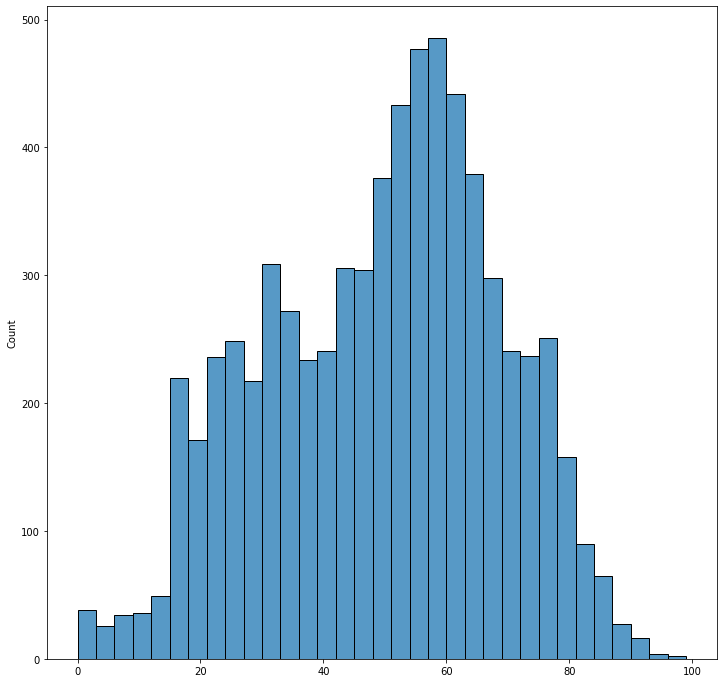

In [30]:
fig, ax = plt.subplots(figsize=(12,12))

sns.histplot(ages, kde=False, ax=ax)

plt.show()

## Download IDAT Files for all samples 

In [31]:
def download_idats(gsm_id, gsm_info, output_directory):
    _grn_exists = os.path.exists(os.path.join(output_directory, gsm_info['Grn']))
    _red_exists = os.path.exists(os.path.join(output_directory, gsm_info['Red']))
    if _red_exists and _grn_exists:
        return 0 
    _grn_ftp_path = f'{gsm_info["ftp_head"]}/suppl/{ gsm_info["Grn"]}'
    _red_ftp_path = f'{gsm_info["ftp_head"]}/suppl/{ gsm_info["Red"]}'
    _grn_wget_command = ['wget', '-q','--limit-rate=5M', '-nd', '-P',
                         output_directory, _grn_ftp_path]
    _red_wget_command = ['wget', '-q','--limit-rate=5M', '-nd', '-P',
                         output_directory, _red_ftp_path]
    _g = subprocess.Popen(args=_grn_wget_command)
    _r = subprocess.Popen(args=_red_wget_command)
    _g.wait()
    _r.wait()    
    if _g.returncode or _r.returncode:
        return gsm_id
    else:
        return 0

In [32]:
download_status = joblib.Parallel(n_jobs=8, verbose=10)(joblib.delayed(download_idats)
                                                       (*[gsm_id, gsm_info, idat_dir]) for gsm_id, gsm_info in idat_sample_meta.items())

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.1466s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0146s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0055s.) Setting batch_size=8.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0030s.) Setting batch_size=16.
[Parallel(n_jobs=8)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0065s.) Setting batch_size=32.
[Parallel(n_jobs=8)]: Done 320 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Bat

## Validate IDAT Files

In [33]:
def check_idat_files(gsm_meta, idat_directory):
    idat_files = [os.path.exists(os.path.join(idat_directory, gsm_meta["Grn"])),
                  os.path.exists(os.path.join(idat_directory, gsm_meta["Red"]))]
    if not all(idat_files):
        return 1
    return 0

In [34]:
all_sample_meta = {gsm_id: gsm_meta for gsm_id, gsm_meta 
                   in idat_sample_meta.items() if not check_idat_files(gsm_meta, idat_dir)}

In [35]:
Counter([x['experiment_id'] for x in all_sample_meta.values()])

Counter({'GSE51057': 329,
         'GSE51032': 516,
         'GSE87571': 732,
         'GSE125105': 699,
         'GSE42861': 689,
         'GSE69138': 185,
         'GSE111629': 571,
         'GSE128235': 537,
         'GSE121633': 480,
         'GSE87648': 384,
         'GSE73103': 355,
         'GSE61496': 312,
         'GSE59065': 296,
         'GSE87640': 240,
         'GSE97362': 235,
         'GSE156994': 219,
         'GSE128064': 112,
         'GSE43976': 95})

## Process IDAT Files
- Batch samples
    - Samples batched within experiments and all sample proccessed on same array are always in the same batch

In [36]:
process_exps = set([sample['experiment_id'] for sample in all_sample_meta.values()])

In [37]:
processing_batches = []

for exp in process_exps:
    exp_samples = []
    for gsm_info in all_sample_meta.values():
        if gsm_info['experiment_id'] == exp:
            exp_samples.append(gsm_info['Red'].replace('_Red.idat.gz', ''))
    exp_samples.sort()
    
    # collect samples assayed on same array
    chip_ids = Counter([sample.split('_')[1] for sample in exp_samples])
    chip_size = math.ceil(np.mean(list(chip_ids.values())))
    
    batch_size = 60
    while True:
        batch_remainder = len(exp_samples) % batch_size
        if batch_remainder < 10:
            batch_size += chip_size
        else:
            break
    ## keep samples assayed on sample chip together
    exp_chip_samples = defaultdict(list)
    for sample in exp_samples:
        exp_chip_samples[sample.split('_')[1]].append(sample)
    
    for slide in exp_chip_samples:
        exp_chip_samples[slide].sort(key = lambda x: x.split('_')[2])
        
    batch, batch_count = [], 1
    for slide, slide_samples in exp_chip_samples.items():
        if len(batch) + len(slide_samples) > batch_size:
            processing_batches.append([f'{exp}_{batch_count}', batch])
            batch = []
            batch_count += 1
        for sample in slide_samples:
            batch.append(os.path.join(idat_dir, sample))
    if batch:
        processing_batches.append([f'{exp}_{batch_count}', batch])

In [38]:
cleaned_processing_batches = []

for batch in processing_batches:
    if len(batch[1]) < 24:
        cleaned_processing_batches[-1][1].extend(batch[1])
    else:
        cleaned_processing_batches.append([batch[0], list(batch[1])])

In [39]:
processing_batches = cleaned_processing_batches

In [40]:
# Corrupted idat files in GEO will cause an error to be thrown if processed
corrupted_gsm = {'GSM3668181', 'GSM2337437', 'GSM1235542'}

In [41]:
batch_cmds = {}

for batch in processing_batches:
    batch_path = os.path.join(tmp_dir, f'{batch[0]}.txt')
    with open(batch_path, 'w') as out:
        _batch = [sample for sample in batch[1] if os.path.basename(sample).split('_')[0] not in corrupted_gsm]
        out.write('\n'.join(_batch))
    batch_cmds[batch[0]] = batch_path

In [42]:
def run_minfi_pipeline(minfi_pipeline_path, exp_id, ref_file_path, output_dir):
    if os.path.exists(os.path.join(output_dir, f'{exp_id}_qc.gz')):
        return 0, exp_id
    cmd = ['Rscript', minfi_pipeline_path, exp_id, ref_file_path, output_dir]
    run = subprocess.Popen(cmd)
    run.wait()
    return run.returncode, exp_id

In [43]:
hd = os.getcwd()

In [44]:
#minfi_pipe_path = os.path.join(working_dir, 'minfi_pipeline.R')
minfi_pipe_path = os.path.join(hd, 'minfi_pipeline.R')

In [45]:
%%capture

processed = joblib.Parallel(n_jobs=4, verbose=10)(joblib.delayed(run_minfi_pipeline)(*[minfi_pipe_path, batch, 
                                                                                       batch_path, f'{processed_file_dir}/']) 
                                                  for batch, batch_path in batch_cmds.items())

## Parse Processed Data and Update Sample Metadata

In [46]:
def open_gzip(file_path: str, yield_indices: Union[List[int], None] = None):
    with io.BufferedReader(gzip.open(file_path, 'rb')) as file:
        for line in file:
            d_line = line.decode('utf-8').strip()
            y_line = d_line.replace('"', '').split(',')
            if not yield_indices:
                yield y_line
            else:
                yield [y_line[index] for index in yield_indices]

In [47]:
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return value

In [48]:
def get_meta_data(file_path) -> dict:
    header = None
    meta_data = {}
    for line in open_gzip(file_path):
        if not header:
            header = line[1:]
        else:
            sample = line[0].split('_')[0]
            meta_data[sample] = {f'proc_{key}':convert_to_float(value) for key, value in zip(header, line[1:])}
    return meta_data

In [49]:
unprocessed_batches = [batch for batch in batch_cmds.keys() if not os.path.exists(f'{processed_file_dir}/{batch}_qc.gz')]
unprocessed_exps = set([batch.split('_')[0] for batch in unprocessed_batches])

In [50]:
unprocessed_batches

[]

In [51]:
all_sample_meta = {sample:sample_info for sample, sample_info in all_sample_meta.items() if sample_info['experiment_id'] not in unprocessed_exps}

In [52]:
ref_sample_meta = []

for exp in tqdm(batch_cmds.keys()):
    if exp in unprocessed_batches:
        continue
    exp_id, batch = exp.split('_')
    qc_meta = get_meta_data(f'{processed_file_dir}/{exp}_qc.gz')
    cell_meta = get_meta_data(f'{processed_file_dir}/{exp}_cell_counts.gz')
    for sample in qc_meta:
        sample_qc = qc_meta[sample]
        proc_qc_fail = 0
        if sample_qc['proc_mMed'] < 10.0 or sample_qc['proc_mMed'] < 10.0:
            proc_qc_fail = 1
        all_sample_meta[sample]['proc_qc_fail'] = proc_qc_fail
        all_sample_meta[sample]['batch'] = batch
        all_sample_meta[sample].update(sample_qc)
        all_sample_meta[sample].update(cell_meta[sample])
        all_sample_meta[sample]['processing_complete'] = 1

  0%|          | 0/122 [00:00<?, ?it/s]

In [53]:
sample_meta = {sample:sample_info for sample, sample_info in all_sample_meta.items() if 'processing_complete' in sample_info}

In [54]:
blood_tissue_sources = {'Buffy coat': 'blood',
 'PBL': 'blood',
 'genomic DNA extracted and purified': 'blood',
 'Lynch-like patient. Genomic DNA': 'blood'}

In [55]:
for sample in sample_meta:
    if 'X' == sample_meta[sample]['tissue_source'][0] or 'blood' in sample_meta[sample]['tissue_source'].lower():
        proc_tissue = 'blood'
    else:
        proc_tissue = blood_tissue_sources.get(sample_meta[sample]['tissue_source'], 'NA')
    sample_meta[sample]['proc_tissue'] = proc_tissue

In [56]:
if not os.path.exists(f'{processed_file_dir}/processed_sample_meta.pkl'):
    with open(f'{processed_file_dir}/processed_sample_meta.pkl', 'wb') as out:
        pickle.dump(sample_meta, out)
    with open(f'{processed_file_dir}/processed_ref_meta.pkl', 'wb') as out:
        pickle.dump(ref_sample_meta, out)